In [2]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import curve_fit
import numpy as np
import tensorflow as tf

# %pip install scikit-learn==1.4.2

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using yfinance to extract the financial dataset of Tesla stock whose Ticker is "TSLA"

In [5]:
tesla = yf.Ticker("TSLA")

We want to get the whole dataset starting the beginning day, so we set period=max

In [6]:
tesla_data = tesla.history(period="max")

In [ ]:
# check if the data is a DataFrame
print(type(tesla_data))

<class 'pandas.core.frame.DataFrame'>


Check what information that the dataset stores. In this case, there are 3700+ rows stand for 3700+ days, and 8 colummns stand for the Date, Open, High, Low, Close, Volume, Dividends and Stock Splits

In [ ]:
# resets the index of the tesla_data DataFrame to the default integer index (0, 1, 2, ...), 
# and moves the current index (which is often the 'Date' after downloading from yfinance) back to a regular column.
#tesla_data.reset_index(inplace=True) 
tesla_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...,...
3760,2025-06-10 00:00:00-04:00,314.940002,327.829987,310.670013,326.089996,151256500,0.0,0.0
3761,2025-06-11 00:00:00-04:00,334.399994,335.500000,322.500000,326.429993,122611400,0.0,0.0
3762,2025-06-12 00:00:00-04:00,323.079987,332.559998,316.859985,319.109985,105127500,0.0,0.0
3763,2025-06-13 00:00:00-04:00,313.970001,332.989990,313.299988,325.309998,128495300,0.0,0.0


In [8]:
tesla_data.shape

(3765, 8)

-Using describe() function to get overall insight of the data, including the number of data point/sample, mean value, standard deviation,max, min,  of each features.

-The 25%, 50% and 75% rows show the percentile of each features, which are less than or equal to the corresponding values.

-As we can see, there is a big jump from 75%(~188) to maximum values (~475). This may indicate there are outlier in the dataset.

In [9]:
tesla_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3765.000000,3765.000000,3765.000000,3765.000000,3.765000e+03,3765.0,3765.000000
mean,88.593040,90.581117,86.465378,88.567852,9.707473e+07,0.0,0.002125
std,113.848708,116.450259,110.987632,113.754319,7.689792e+07,0.0,0.095018
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06,0.0,0.000000
25%,12.446667,12.764667,12.183333,12.506000,5.014650e+07,0.0,0.000000
50%,18.799999,19.118668,18.466667,18.807333,8.319150e+07,0.0,0.000000
75%,191.456665,196.360001,186.339996,191.300003,1.225740e+08,0.0,0.000000
max,475.899994,488.540009,457.510010,479.859985,9.140820e+08,0.0,5.000000


To investigate the outlier, use boxplot to see how the distribution of each features looks like. Since the Oopen, High, Low, CLose values are similar to each other, I just plot the Close prices.

- As shown by the table above, and visualized by the box plot below, there are 25% of closing price are =< 12.5 USD, 50% are =< 18.79 USD, and 75% are =< 191 USD. The remaining 25% of price has outliers which the highest value hits up to 480 USD.

- The distribution is skew by the outlier, where the first half of the data accounts for low price less than 18.79 USD, while the second half of the data witnesses a remarkable grow up. This insight also indicate a rapid increase of TESLA business in the recent 5 years.

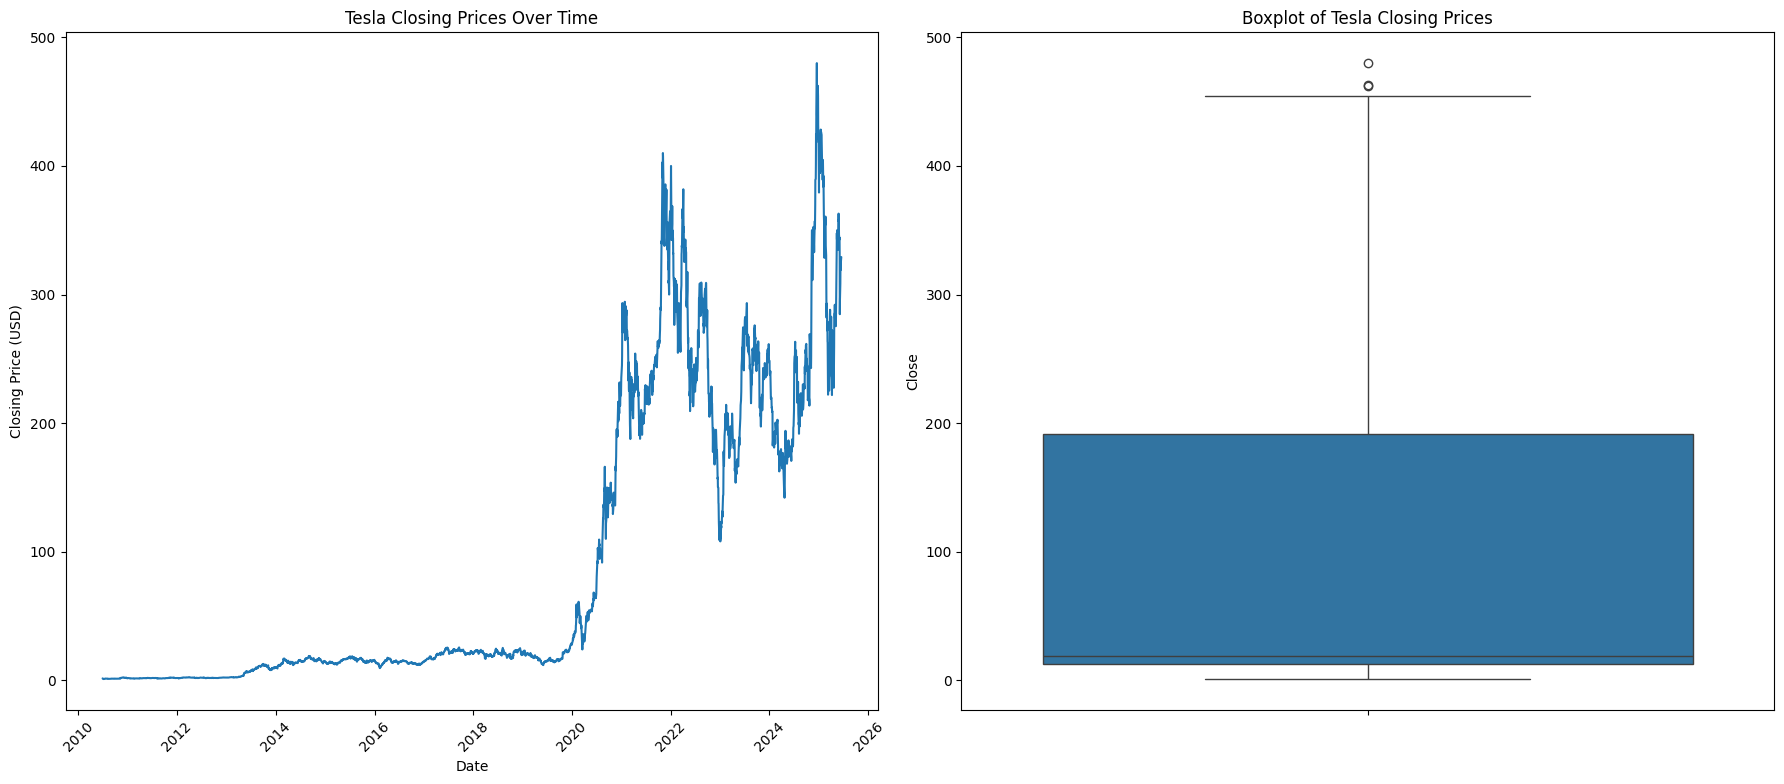

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.set(style="whitegrid")
sns.lineplot(data=tesla_data, x="Date", y="Close", ax=axes[0])
axes[0].set_title("Tesla Closing Prices Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Closing Price (USD)")
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(data=tesla_data, y="Close", ax=axes[1])
axes[1].set_title("Boxplot of Tesla Closing Prices")

plt.tight_layout()
plt.show()


In [11]:
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3765 entries, 0 to 3764
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          3765 non-null   datetime64[ns, America/New_York]
 1   Open          3765 non-null   float64                         
 2   High          3765 non-null   float64                         
 3   Low           3765 non-null   float64                         
 4   Close         3765 non-null   float64                         
 5   Volume        3765 non-null   int64                           
 6   Dividends     3765 non-null   float64                         
 7   Stock Splits  3765 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 235.4 KB


************************************************** MODELING **************************************************

- In this section, I build models to predict the next day closing price for tesla, using the historical stock data above. Specifically, I use the Linear Regression model as a baseline prediction, then develope time-series LSTMs models, using different look back days (30, 60, 90, 120) for the prediction. These look back days are the number of previous days grouped together, used for training and prediction.  

- There are five models in total: one linear reg and 4 LSTM models.

- These model are then validated by regression metrics: MSE, RMSE, MAE, MAPE, MADE, R2 score.

###################################### Data Preprocessing ################################
- define 5 features, sequence_lengths used for training data

- define metrics used to evaluate model

- Scale data to make sure all feature are in the similar ans small range (0,1), since LSTM models are sensitive to the magnitude of input data

- The scaled data is the old data but in this case, there are only 5 features are kept for model training, and their magnitude is normalized in the same scale (0,1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb

# Define features and sequence lengths for training data
features = ['Open', 'High', 'Low', 'Close', 'Volume']

sequence_lengths = [30, 60, 90, 120]

#define metrics to evaluate the model
results = {
    "sequence_length": [],
    "MSE": [],
    "RMSE": [],
    "MAE": [],
    "MAPE": [],
    "R2": []
}

all_predictions = {}
all_actuals = {}

# Scale the data. The MinMaxScaler and fit_transform method will scale the features on a DataFrame to a range between 0 and 1, 
# and output the scaled values as a NumPy array.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tesla_data[features])
print("type of scaled_data:",type(scaled_data))

#now we check how the scaled data looks like
#scaled_data = pd.DataFrame(scaled_data, columns=features)
print(scaled_data[:5])  # Display the first 5 rows of scaled data
# Check the shape of the scaled data
print("shape of scaled_data:",scaled_data.shape)


type of scaled_data: <class 'numpy.ndarray'>
first 5 rows of scaled_data:
[[4.01553072e-04 1.14477655e-03 3.73848278e-04 1.12641280e-03
  3.06604867e-01]
 [1.35488746e-03 1.88607712e-03 1.21501043e-03 1.11805880e-03
  2.80639852e-01]
 [1.24397043e-03 1.27060568e-03 7.72524114e-04 8.57688465e-04
  1.33184151e-01]
 [9.63163140e-04 8.84910159e-04 5.44709462e-04 4.73399704e-04
  8.25596059e-02]
 [5.41954584e-04 4.60918247e-04 1.24128387e-04 4.31634707e-05
  1.10956375e-01]]
shape of scaled_data: (3765, 5)


###################################### Data Praperation ################################
As shown above, the scaled data consists of 3765 days and 5 features. Now we slice the data corresponding to the sequence length value. In particular,

- input data for training: from days (i-sequence_length) to day (i-1). Ex: seq_length=30, then [i-30, i-29, ..., i-1]

- target: predict "close" price for day i

I splitted dataset intor 80% for training, and 20% for testing

In [ ]:
for seq_len in sequence_lengths:
    # Prepare data
    X, y = [], []
    for i in range(seq_len, len(scaled_data)):
        X.append(scaled_data[i-seq_len:i])  # input: days (i-sequence_length) to day (i-1). Ex: seq_length=30, then [i-30, i-29, ..., i-1]
        y.append(scaled_data[i, features.index('Close')]) # target: predict "close" price for day i
    X, y = np.array(X), np.array(y)
    print(f"Shape of X for sequence length {seq_len}: {X.shape}")
    print(f"Shape of y for sequence length {seq_len}: {y.shape}")
    # Train/test split
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    print(f"Train/Test split for sequence length {seq_len}:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print("------------------------------------------------------------------------")
    

Shape of X for sequence length 30: (3735, 30, 5)
Shape of y for sequence length 30: (3735,)
y shape == (3735,).
Train/Test split for sequence length 30:
X_train shape: (2988, 30, 5), y_train shape: (2988,)
X_test shape: (747, 30, 5), y_test shape: (747,)
------------------------------------------------------------------------
Shape of X for sequence length 60: (3705, 60, 5)
Shape of y for sequence length 60: (3705,)
y shape == (3705,).
Train/Test split for sequence length 60:
X_train shape: (2964, 60, 5), y_train shape: (2964,)
X_test shape: (741, 60, 5), y_test shape: (741,)
------------------------------------------------------------------------
Shape of X for sequence length 90: (3675, 90, 5)
Shape of y for sequence length 90: (3675,)
y shape == (3675,).
Train/Test split for sequence length 90:
X_train shape: (2940, 90, 5), y_train shape: (2940,)
X_test shape: (735, 90, 5), y_test shape: (735,)
------------------------------------------------------------------------
Shape of X for s

########################################### Model Architecture #################################################
1st LSTM layer: 

units=128: The layer has 128 memory cells (neurons). This determines the dimensionality of the output space for each time step.

return_sequences=True: The layer will return the full sequence of outputs for each input sequence (not just the last output). This is needed when stacking LSTM layers, so the next LSTM layer receives a sequence as input.

input_shape=(X.shape[1], X.shape[2]):
X.shape[1] is the sequence length (number of time steps, e.g., 30, 60, 90, or 120).
X.shape[2] is the number of features per time step (here, 5: Open, High, Low, Close, Volume).

by default, LSTM uses activation='tanh' for the cell state updates so I dont need to specify one here.


2nd LSTM layer:

units=128: This layer has 128 memory cells (neurons), so it will output a vector of length 128 for each input sequence.

return_sequences=False:
This means the layer will output only the last hidden state (not the full sequence of outputs).
The output shape will be (batch_size, 128) instead of (batch_size, sequence_length, 128).

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))) # input_shape = (sequence_length, number_of_features): matrix of shape (seq_len, 5)
model.add(LSTM(units=128, return_sequences=False))  # Last LSTM layer, return_sequences defaults to False
model.add(Dense(1)) # Output layer, output predicted close price for only the next day

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# # Fit the model
#model.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=False, verbose=0)


# # Predict
# predictions = model.predict(X_test)


# # Reshape predictions to match the original scale
# close_scaler = MinMaxScaler()
# close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
# predictions = close_scaler.inverse_transform(predictions.reshape(-1, 1))
# actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# all_predictions[seq_len] = predictions
# all_actuals[seq_len] = actual

# ##################################################### Metrics Calculation - VALIDATION ##########################################################
# mse = mean_squared_error(actual, predictions)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(actual, predictions)
# mape = mean_absolute_percentage_error(actual, predictions) * 100
# r2 = r2_score(actual, predictions)


# # Store results
# results["sequence_length"].append(seq_len)
# results["MSE"].append(mse)
# results["RMSE"].append(rmse)
# results["MAE"].append(mae)
# results["MAPE"].append(mape)
# results["R2"].append(r2)

# # Display results
# results_df = pd.DataFrame(results)
# display(results_df)

/home/hp/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 120, 128)       │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,321 (782.50 KB)

 Trainable params: 200,321 (782.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
print("input_shape for LSTM: #training samples/days :", X_train.shape[0], "--- number of features:", X_train.shape[1])
#print("input_shape:", (X.shape[1], X.shape[2])) ,"---- sequence length:", X_train.shape[2]
# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

input_shape for LSTM: #training samples/days : 3004 --- number of features: 5
X_train shape: (3004, 5)
X_test shape: (752, 5)
y_train shape: (3004,)
y_test shape: (752,)


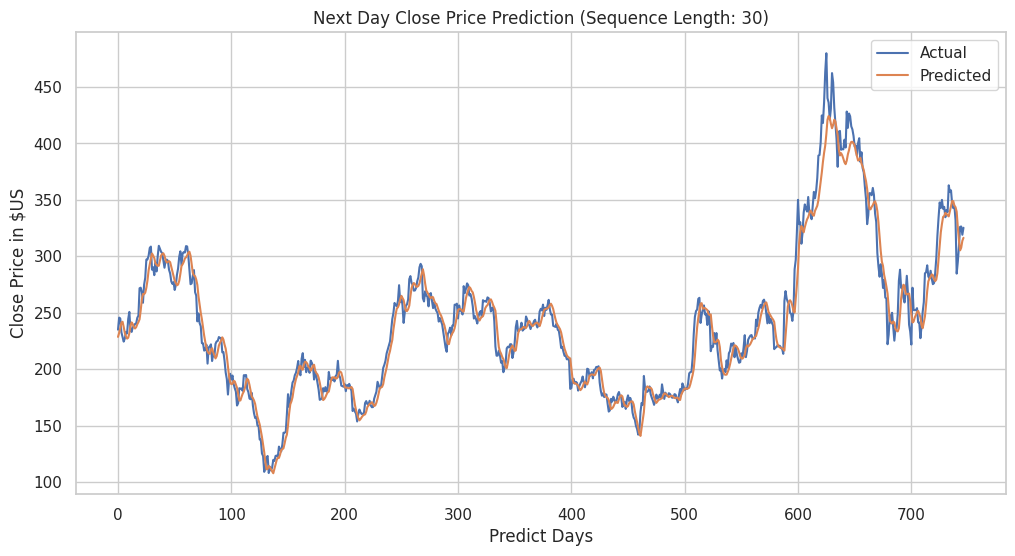

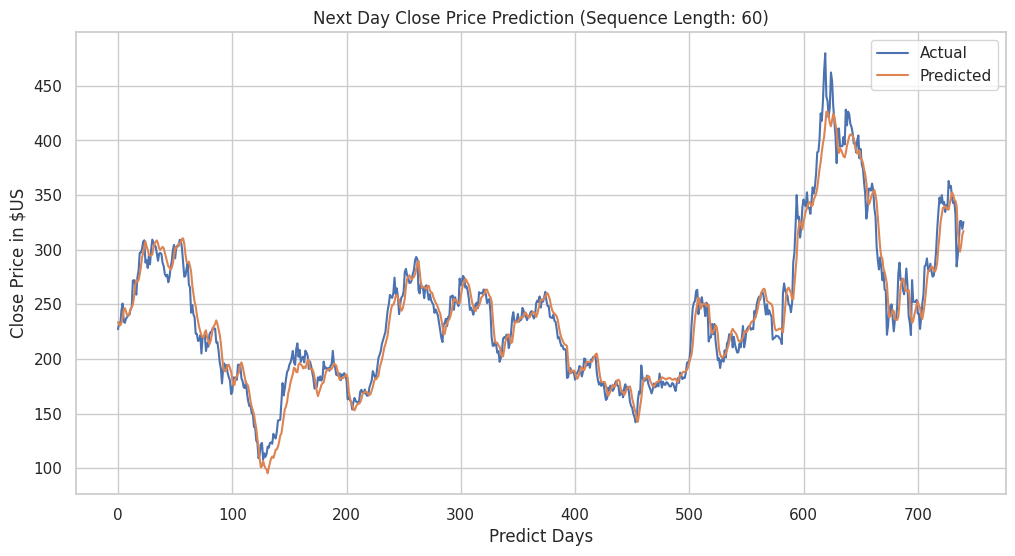

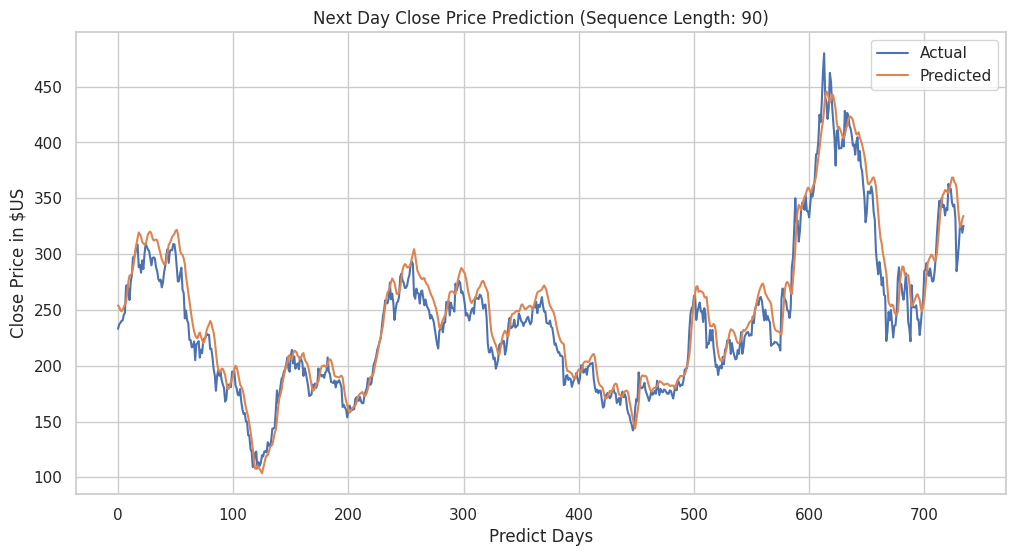

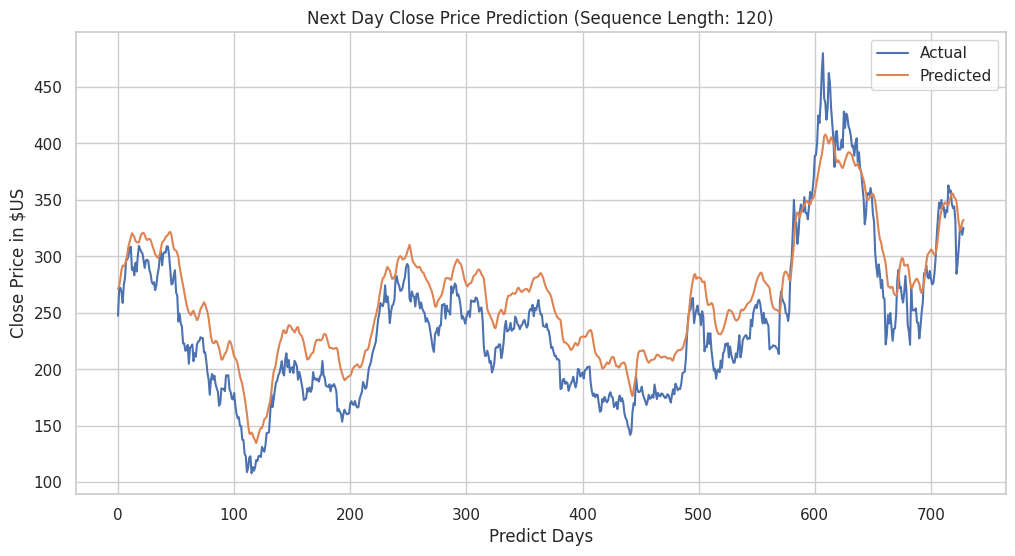

In [ ]:
#plot the results
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt


for seq_len in sequence_lengths:
    plt.figure(figsize=(12,6))
    plt.plot(all_actuals[seq_len], label='Actual')
    plt.plot(all_predictions[seq_len], label='Predicted')
    plt.xlabel('Predict Days')
    plt.ylabel('Close Price in $US')
    plt.title(f'Next Day Close Price Prediction (Sequence Length: {seq_len})')
    plt.legend()
    plt.show()


************ Training with LInear Regression as a baseline, to compare with LSTMs results ************
******************************************************************************************************

,Metric,Value
0,Mean Squared Error (MSE),90.987511
1,Root Mean Squared Error (RMSE),9.538737
2,Mean Absolute Error (MAE),6.837980
3,Mean Absolute Percentage Error (MAPE) (%),2.866882
4,R2,0.978744


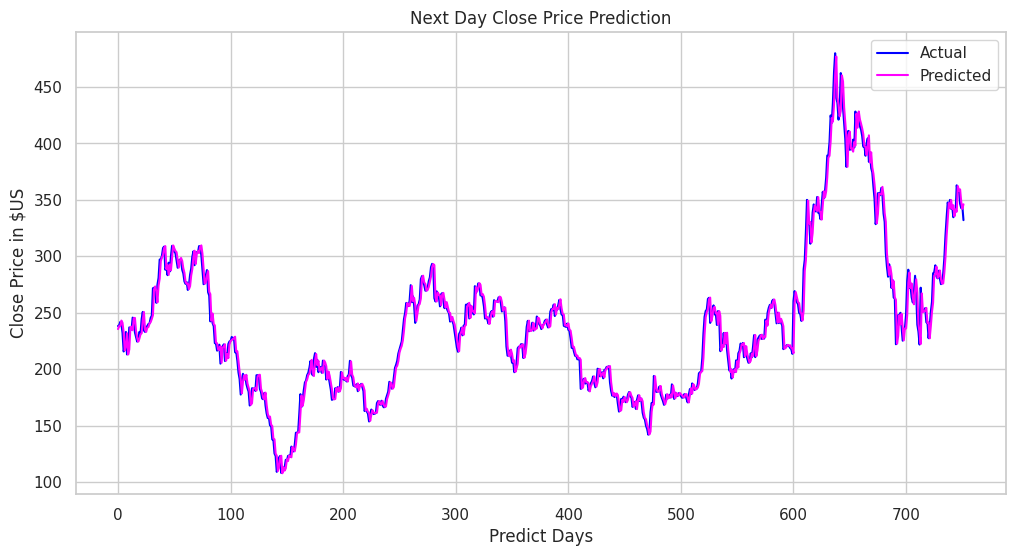

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare data
tesla_data['Tomorrow_Close'] = tesla_data['Close'].shift(-1)  # Target is next day's close
tesla_data.dropna(inplace=True)  # Remove rows with NaNs

# Features and target
X = tesla_data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = tesla_data['Tomorrow_Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and visualize
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd

# Calculate evaluation metrics
mse_linreg = mean_squared_error(y_test, predictions)
rmse_linreg = np.sqrt(mse_linreg)
mae_linreg = mean_absolute_error(y_test, predictions)
mape_linreg = mean_absolute_percentage_error(y_test, predictions) * 100
r2_linreg = r2_score(y_test, predictions)


# Create a DataFrame for metrics
metrics = {
    "Metric": ["Mean Squared Error (MSE)", 
               "Root Mean Squared Error (RMSE)", 
               "Mean Absolute Error (MAE)",
               "Mean Absolute Percentage Error (MAPE) (%)",
               "R2"],
    "Value": [mse_linreg, rmse_linreg, mae_linreg,  mape_linreg, r2_linreg]
}



metrics_df = pd.DataFrame(metrics)
display(metrics_df)

plt.figure(figsize=(12,6))
#new color
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='magenta')
plt.xlabel('Predict Days')
plt.ylabel('Close Price in $US')
plt.title('Next Day Close Price Prediction')
plt.legend()
plt.show()

********************** Benchmark all model performance **************************

In [ ]:
import pandas as pd
for seq_len in sequence_lengths:
    mse = results_df[results_df['sequence_length'] == seq_len]['MSE'].values[0]
    rmse = results_df[results_df['sequence_length'] == seq_len]['RMSE'].values[0]
    mae = results_df[results_df['sequence_length'] == seq_len]['MAE'].values[0]
    mape = results_df[results_df['sequence_length'] == seq_len]['MAPE'].values[0]
    r2 = results_df[results_df['sequence_length'] == seq_len]['R2'].values[0]

    # Create a DataFrame for metrics
    metrics = {
        "Metric": ["Mean Squared Error (MSE)", 
                   "Root Mean Squared Error (RMSE)", 
                   "Mean Absolute Error (MAE)",
                   "Mean Absolute Percentage Error (MAPE) (%)",
                   "R2"],
        "Value": [mse, rmse, mae,  mape, r2]
    }
    # metrics_df = pd.DataFrame(metrics)
    # display(metrics_df)

# Create a summary DataFrame for all models
mse_30 = results_df[results_df['sequence_length'] == 30]['MSE'].values[0]
mse_60 = results_df[results_df['sequence_length'] == 60]['MSE'].values[0]
mse_90 = results_df[results_df['sequence_length'] == 90]['MSE'].values[0]
mse_120 = results_df[results_df['sequence_length'] == 120]['MSE'].values[0]

rmse_30 = results_df[results_df['sequence_length'] == 30]['RMSE'].values[0]
rmse_60 = results_df[results_df['sequence_length'] == 60]['RMSE'].values[0]
rmse_90 = results_df[results_df['sequence_length'] == 90]['RMSE'].values[0]
rmse_120 = results_df[results_df['sequence_length'] == 120]['RMSE'].values[0]

mae_30 = results_df[results_df['sequence_length'] == 30]['MAE'].values[0]
mae_60 = results_df[results_df['sequence_length'] == 60]['MAE'].values[0]
mae_90 = results_df[results_df['sequence_length'] == 90]['MAE'].values[0]
mae_120 = results_df[results_df['sequence_length'] == 120]['MAE'].values[0]

mape_30 = results_df[results_df['sequence_length'] == 30]['MAPE'].values[0]
mape_60 = results_df[results_df['sequence_length'] == 60]['MAPE'].values[0]
mape_90 = results_df[results_df['sequence_length'] == 90]['MAPE'].values[0]
mape_120 = results_df[results_df['sequence_length'] == 120]['MAPE'].values[0]

r2_30 = results_df[results_df['sequence_length'] == 30]['R2'].values[0]
r2_60 = results_df[results_df['sequence_length'] == 60]['R2'].values[0]
r2_90 = results_df[results_df['sequence_length'] == 90]['R2'].values[0]
r2_120 = results_df[results_df['sequence_length'] == 120]['R2'].values[0]

# Create a summary DataFrame for all models
results = {
    "Model": ["Linear Regression", "LSTM (30 days)", "LSTM (60 days)", "LSTM (90 days)", "LSTM (120 days)"],
    "Mean Squared Error (MSE)": [mse_linreg, mse_30, mse_60, mse_90, mse_120],
    "Root Mean Squared Error (RMSE)": [rmse_linreg, rmse_30, rmse_60, rmse_90, rmse_120],
    "Mean Absolute Error (MAE)": [mae_linreg, mae_30, mae_60, mae_90, mae_120],
    "Mean Absolute Percentage Error (MAPE) (%)": [mape_linreg, mape_30, mape_60, mape_90, mape_120],
    "R2": [r2_linreg, r2_30, r2_60, r2_90, r2_120]
}

summary_df = pd.DataFrame(results)
display(summary_df)

,Model,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),Mean Absolute Percentage Error (MAPE) (%),R2
0,Linear Regression,94.868862,9.740065,6.946048,2.902095,0.977957
1,LSTM (30 days),187.159638,13.680630,9.795276,4.020240,0.957055
2,LSTM (60 days),191.899726,13.852788,10.219787,4.358753,0.956314
3,LSTM (90 days),295.663471,17.194868,13.442022,5.696983,0.933229
4,LSTM (120 days),988.581975,31.441723,28.733178,13.454586,0.778560
